# MUSIC Spectrum Explorer

Interactive notebook for visualizing MUSIC spectrum lobes across all angles.

**Features:**
- Select dataset (frequency) to analyze
- Visualize MUSIC spectrum for each true angle
- See the full spectrum "lobes" showing how estimates are derived
- Uses proper configuration from `constants.py`

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

# Reload constants to ensure latest version
import importlib
import constants
importlib.reload(constants)

from constants import (
    create_rotated_uca, 
    CHANNEL_ORDER, 
    RADIUS, 
    ARRAY_ROTATION,
    C
)
from doa_py.algorithm.music_based import music

print("Configuration loaded:")
print(f"  Channel order: {CHANNEL_ORDER}")
print(f"  Array rotation: {ARRAY_ROTATION}°")
print(f"  Array radius: {RADIUS*1000:.1f} mm")

Configuration loaded:
  Channel order: [2, 3, 0, 1]
  Array rotation: 155.0°
  Array radius: 30.0 mm


## Dataset Selection

Choose which dataset to analyze by setting `SELECTED_DATASET` below.

In [12]:
# =============================================================================
# DATASET SELECTION - Change this to analyze different frequencies
# =============================================================================

# Available options:
#   '1200MHz_10deg' - 1.2 GHz, 10° increments (36 angles)
#   '1200MHz_1deg'  - 1.2 GHz, 1° increments (360 angles) - DETAILED
#   '1500MHz_10deg' - 1.5 GHz, 10° increments (36 angles)
#   '2000MHz_10deg' - 2.0 GHz, 10° increments (36 angles)
#   '2400MHz_10deg' - 2.4 GHz, 10° increments (36 angles)
#   '3000MHz_10deg' - 3.0 GHz, 10° increments (36 angles)
#   '4000MHz_10deg' - 4.0 GHz, 10° increments (36 angles)
#   '5000MHz_10deg' - 5.0 GHz, 10° increments (36 angles)
#   '5700MHz_10deg' - 5.7 GHz, 10° increments (36 angles)
#   '5700MHz_1deg'  - 5.7 GHz, 1° increments (360 angles) - DETAILED
#   '5800MHz_10deg' - 5.8 GHz, 10° increments (36 angles)
#   '6000MHz_10deg' - 6.0 GHz, 10° increments (36 angles)

SELECTED_DATASET = '1200MHz_1deg'  # <-- CHANGE THIS TO SELECT DATASET

# =============================================================================

# Dataset definitions
DATASETS = {
    '1200MHz_10deg': {'freq_hz': 1.2e9, 'data_dir': '1200MHz, 0dB, 10deg increments, outside', 'step': 10},
    '1200MHz_1deg':  {'freq_hz': 1.2e9, 'data_dir': '1200MHz, 0dB, 1deg increments, outside', 'step': 1},
    '1500MHz_10deg': {'freq_hz': 1.5e9, 'data_dir': '1500MHz, 0dB, 10deg increments, outside', 'step': 10},
    '2000MHz_10deg': {'freq_hz': 2.0e9, 'data_dir': '2000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '2400MHz_10deg': {'freq_hz': 2.4e9, 'data_dir': '2400MHz, 0dB, 10deg increments, outside', 'step': 10},
    '3000MHz_10deg': {'freq_hz': 3.0e9, 'data_dir': '3000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '4000MHz_10deg': {'freq_hz': 4.0e9, 'data_dir': '4000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5000MHz_10deg': {'freq_hz': 5.0e9, 'data_dir': '5000MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5700MHz_10deg': {'freq_hz': 5.7e9, 'data_dir': '5700MHz, 0dB, 10deg increments, outside', 'step': 10},
    '5700MHz_1deg':  {'freq_hz': 5.7e9, 'data_dir': '5700MHz, 0dB, 1deg increments, outside', 'step': 1},
    '5800MHz_10deg': {'freq_hz': 5.8e9, 'data_dir': '5800MHz, 0dB, 10deg increments, outside', 'step': 10},
    '6000MHz_10deg': {'freq_hz': 6.0e9, 'data_dir': '6000MHz, 0dB, 10deg increments, outside', 'step': 10},
}

# Get selected config
config = DATASETS[SELECTED_DATASET]
FREQ_HZ = config['freq_hz']
DATA_DIR = os.path.join('../data', config['data_dir'])
ANGLE_STEP = config['step']
WAVELENGTH = C / FREQ_HZ

print(f"\n{'='*60}")
print(f"SELECTED: {SELECTED_DATASET}")
print(f"{'='*60}")
print(f"  Frequency: {FREQ_HZ/1e9:.1f} GHz")
print(f"  Wavelength: {WAVELENGTH*1000:.1f} mm")
print(f"  Array size: {RADIUS/WAVELENGTH:.2f} λ")
print(f"  Angle step: {ANGLE_STEP}°")
print(f"  Data path: {DATA_DIR}")

# Check if data exists
if os.path.exists(DATA_DIR):
    angles_available = [int(d.replace('deg', '')) for d in os.listdir(DATA_DIR) if d.endswith('deg')]
    print(f"  Angles available: {len(angles_available)} ({min(angles_available)}° to {max(angles_available)}°)")
else:
    print(f"  ERROR: Data directory not found!")


SELECTED: 1200MHz_1deg
  Frequency: 1.2 GHz
  Wavelength: 250.0 mm
  Array size: 0.12 λ
  Angle step: 1°
  Data path: ../data/1200MHz, 0dB, 1deg increments, outside
  Angles available: 360 (0° to 359°)


In [13]:
# Core functions

def load_cs16(filepath):
    """Load complex IQ data from .cs16 file."""
    raw = np.fromfile(filepath, dtype=np.int16)
    return raw[0::2] + 1j * raw[1::2]


def load_measurement(base_dir, angle):
    """Load measurement data with correct channel ordering."""
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    raw_data = np.vstack(channels)
    return raw_data[CHANNEL_ORDER]  # Apply channel reordering


def extract_tone_snapshots(X, n_snapshots=2048, fft_size=1024):
    """Extract narrowband snapshots at the tone frequency."""
    n_samples = X.shape[1]
    
    # Find tone frequency
    fft_full = fft(X[0])
    peak_idx = np.argmax(np.abs(fft_full[1:n_samples//2])) + 1
    norm_freq = peak_idx / n_samples
    tone_bin = int(norm_freq * fft_size)
    
    # Extract snapshots
    snapshots = []
    hop = fft_size // 2
    for start in range(0, n_samples - fft_size, hop):
        if len(snapshots) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        snapshots.append(fft_seg[:, tone_bin])
    
    return np.array(snapshots).T


def circular_error(est, true):
    """Calculate angular error with wraparound handling."""
    err = est - true
    while err > 180:
        err -= 360
    while err < -180:
        err += 360
    return err


print("Functions defined ✓")

Functions defined ✓


In [14]:
# Create the rotated UCA
uca = create_rotated_uca()

# Angle grids for MUSIC spectrum
angle_grids = np.arange(-180, 180, 1)

print("UCA element positions:")
for i, pos in enumerate(uca.array_position):
    angle = np.rad2deg(np.arctan2(pos[1], pos[0]))
    print(f"  Element {i}: {angle:+7.1f}°")

UCA element positions:
  Element 0:  +155.0°
  Element 1:  -115.0°
  Element 2:   -25.0°
  Element 3:   +65.0°


## Process All Angles and Collect Spectra

In [15]:
# Get list of angles to process
test_angles = list(range(0, 360, ANGLE_STEP))

print(f"Processing {len(test_angles)} angles for {SELECTED_DATASET}...")
print()

# Storage for results
results = {
    'true_angles': [],
    'estimates': [],
    'errors': [],
    'spectra': []  # Full MUSIC spectra for visualization
}

for idx, true_angle in enumerate(test_angles):
    try:
        # Load data
        X = load_measurement(DATA_DIR, true_angle)
        snapshots = extract_tone_snapshots(X, n_snapshots=2048)
        
        # Run MUSIC
        spectrum = music(
            received_data=snapshots,
            num_signal=1,
            array=uca,
            signal_fre=FREQ_HZ,
            angle_grids=angle_grids,
            unit="deg"
        )
        
        # Get estimate
        est = angle_grids[np.argmax(spectrum)]
        
        # Calculate error
        true_adj = true_angle if true_angle <= 180 else true_angle - 360
        err = circular_error(est, true_adj)
        
        # Store results
        results['true_angles'].append(true_angle)
        results['estimates'].append(est)
        results['errors'].append(err)
        results['spectra'].append(spectrum)
        
        # Progress
        if (idx + 1) % 10 == 0 or (idx + 1) == len(test_angles):
            print(f"  Processed {idx+1}/{len(test_angles)} angles")
            
    except Exception as e:
        print(f"  Error at {true_angle}°: {e}")

# Calculate statistics
errors = np.array(results['errors'])
rmse = np.sqrt(np.mean(errors**2))
mean_err = np.mean(errors)

print(f"\nResults:")
print(f"  Angles processed: {len(results['true_angles'])}")
print(f"  RMSE: {rmse:.1f}°")
print(f"  Mean error: {mean_err:+.1f}°")

Processing 360 angles for 1200MHz_1deg...

  Processed 10/360 angles
  Processed 20/360 angles
  Processed 30/360 angles
  Processed 40/360 angles
  Processed 50/360 angles
  Processed 60/360 angles
  Processed 70/360 angles
  Processed 80/360 angles
  Processed 90/360 angles
  Processed 100/360 angles
  Processed 110/360 angles
  Processed 120/360 angles
  Processed 130/360 angles
  Processed 140/360 angles
  Processed 150/360 angles
  Processed 160/360 angles
  Processed 170/360 angles
  Processed 180/360 angles
  Processed 190/360 angles
  Processed 200/360 angles
  Processed 210/360 angles
  Processed 220/360 angles
  Processed 230/360 angles
  Processed 240/360 angles
  Processed 250/360 angles
  Processed 260/360 angles
  Processed 270/360 angles
  Processed 280/360 angles
  Processed 290/360 angles
  Processed 300/360 angles
  Processed 310/360 angles
  Processed 320/360 angles
  Processed 330/360 angles
  Processed 340/360 angles
  Processed 350/360 angles
  Processed 360/360 a

## MUSIC Spectrum Visualization - All Angles

This shows the full MUSIC spectrum for every measured angle, allowing you to see the "lobes" and understand how estimates are derived.

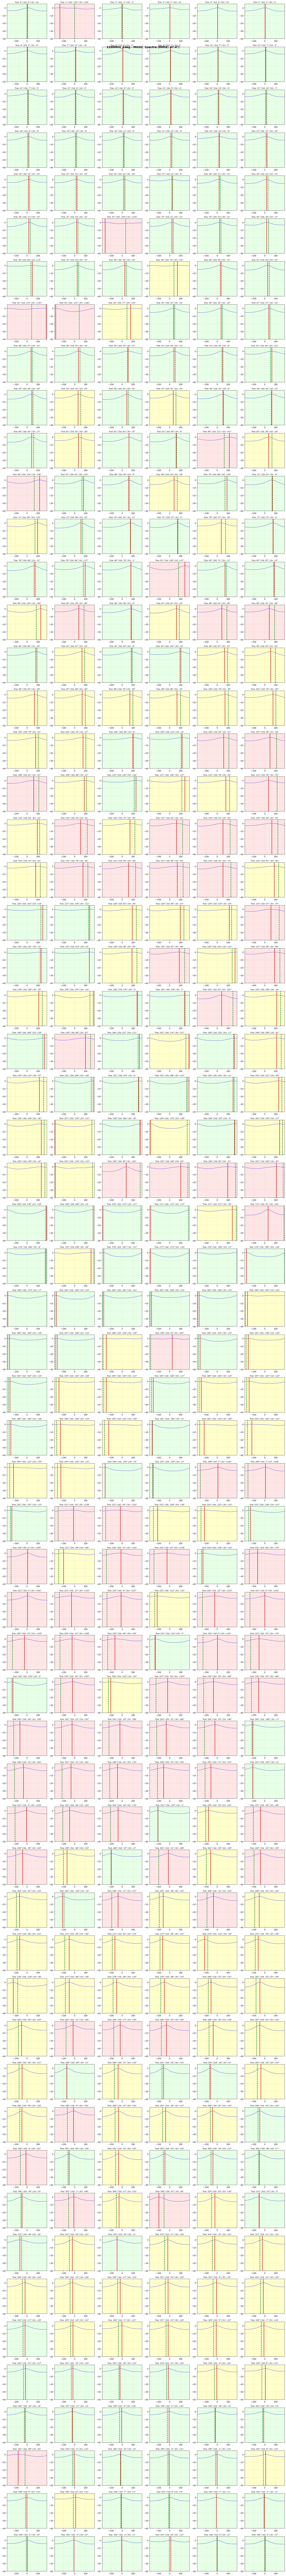


Saved: music_spectra_1200MHz_1deg.png


In [16]:
# Plot MUSIC spectra for all angles in a grid
n_angles = len(results['true_angles'])
n_cols = 6
n_rows = (n_angles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
axes = axes.flatten()

for idx, (true_angle, est, err, spectrum) in enumerate(zip(
    results['true_angles'], results['estimates'], results['errors'], results['spectra']
)):
    ax = axes[idx]
    
    # Normalize spectrum for better visualization
    spectrum_db = 10 * np.log10(spectrum / np.max(spectrum) + 1e-10)
    
    # Plot spectrum
    ax.plot(angle_grids, spectrum_db, 'b-', linewidth=0.8)
    
    # Mark true angle (adjusted to -180 to 180 range)
    true_adj = true_angle if true_angle <= 180 else true_angle - 360
    ax.axvline(true_adj, color='green', linewidth=2, linestyle='--', label=f'True: {true_angle}°')
    
    # Mark estimated angle
    ax.axvline(est, color='red', linewidth=2, linestyle='-', label=f'Est: {est}°')
    
    # Formatting
    ax.set_xlim(-180, 180)
    ax.set_ylim(-40, 5)
    ax.set_title(f'True: {true_angle}° | Est: {est}° | Err: {err:+.0f}°', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Color background based on error magnitude
    if abs(err) < 20:
        ax.set_facecolor('#e6ffe6')  # Green - good
    elif abs(err) < 45:
        ax.set_facecolor('#ffffcc')  # Yellow - moderate
    else:
        ax.set_facecolor('#ffe6e6')  # Red - poor

# Hide unused axes
for idx in range(n_angles, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(f'{SELECTED_DATASET} - MUSIC Spectra (RMSE: {rmse:.1f}°)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'music_spectra_{SELECTED_DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: music_spectra_{SELECTED_DATASET}.png")

## Combined Spectrum Heatmap

A 2D visualization showing all spectra at once - useful for seeing patterns across angles.

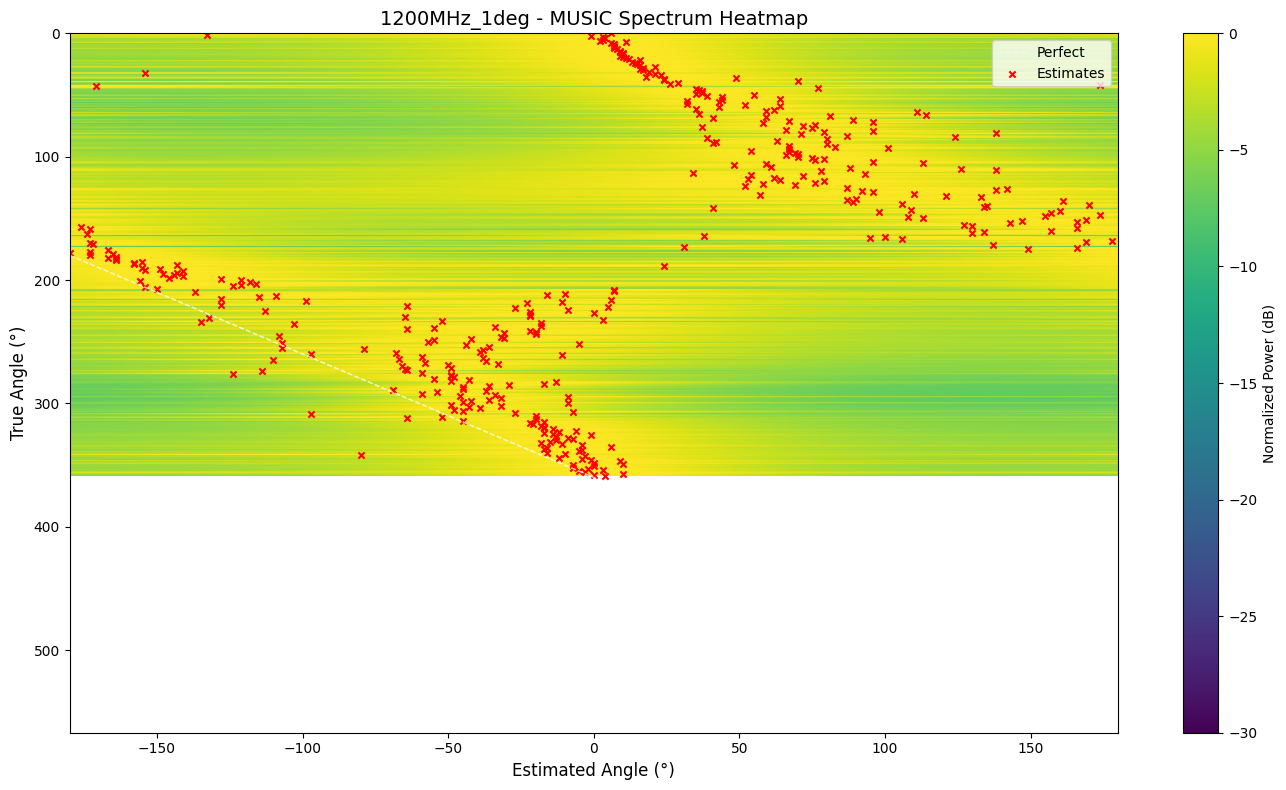


Saved: music_heatmap_1200MHz_1deg.png


In [17]:
# Create heatmap of all spectra
spectra_matrix = np.array(results['spectra'])

# Normalize each row to 0-1
spectra_norm = spectra_matrix / spectra_matrix.max(axis=1, keepdims=True)
spectra_db = 10 * np.log10(spectra_norm + 1e-10)

fig, ax = plt.subplots(figsize=(14, 8))

# Heatmap
im = ax.imshow(spectra_db, aspect='auto', cmap='viridis',
               extent=[-180, 180, results['true_angles'][-1], results['true_angles'][0]],
               vmin=-30, vmax=0)

# Perfect diagonal line (what we'd see with perfect estimates)
ax.plot([-180, 180], [-180+360, 180+360], 'w--', linewidth=1, alpha=0.5, label='Perfect')
ax.plot([-180, 0], [180, 360], 'w--', linewidth=1, alpha=0.5)

# Mark estimates
ax.scatter(results['estimates'], results['true_angles'], c='red', s=20, marker='x', label='Estimates')

ax.set_xlabel('Estimated Angle (°)', fontsize=12)
ax.set_ylabel('True Angle (°)', fontsize=12)
ax.set_title(f'{SELECTED_DATASET} - MUSIC Spectrum Heatmap', fontsize=14)

cbar = plt.colorbar(im, ax=ax, label='Normalized Power (dB)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'music_heatmap_{SELECTED_DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: music_heatmap_{SELECTED_DATASET}.png")

## Polar Spectrum Visualization

Shows the MUSIC spectrum in polar coordinates - more intuitive for angular data.

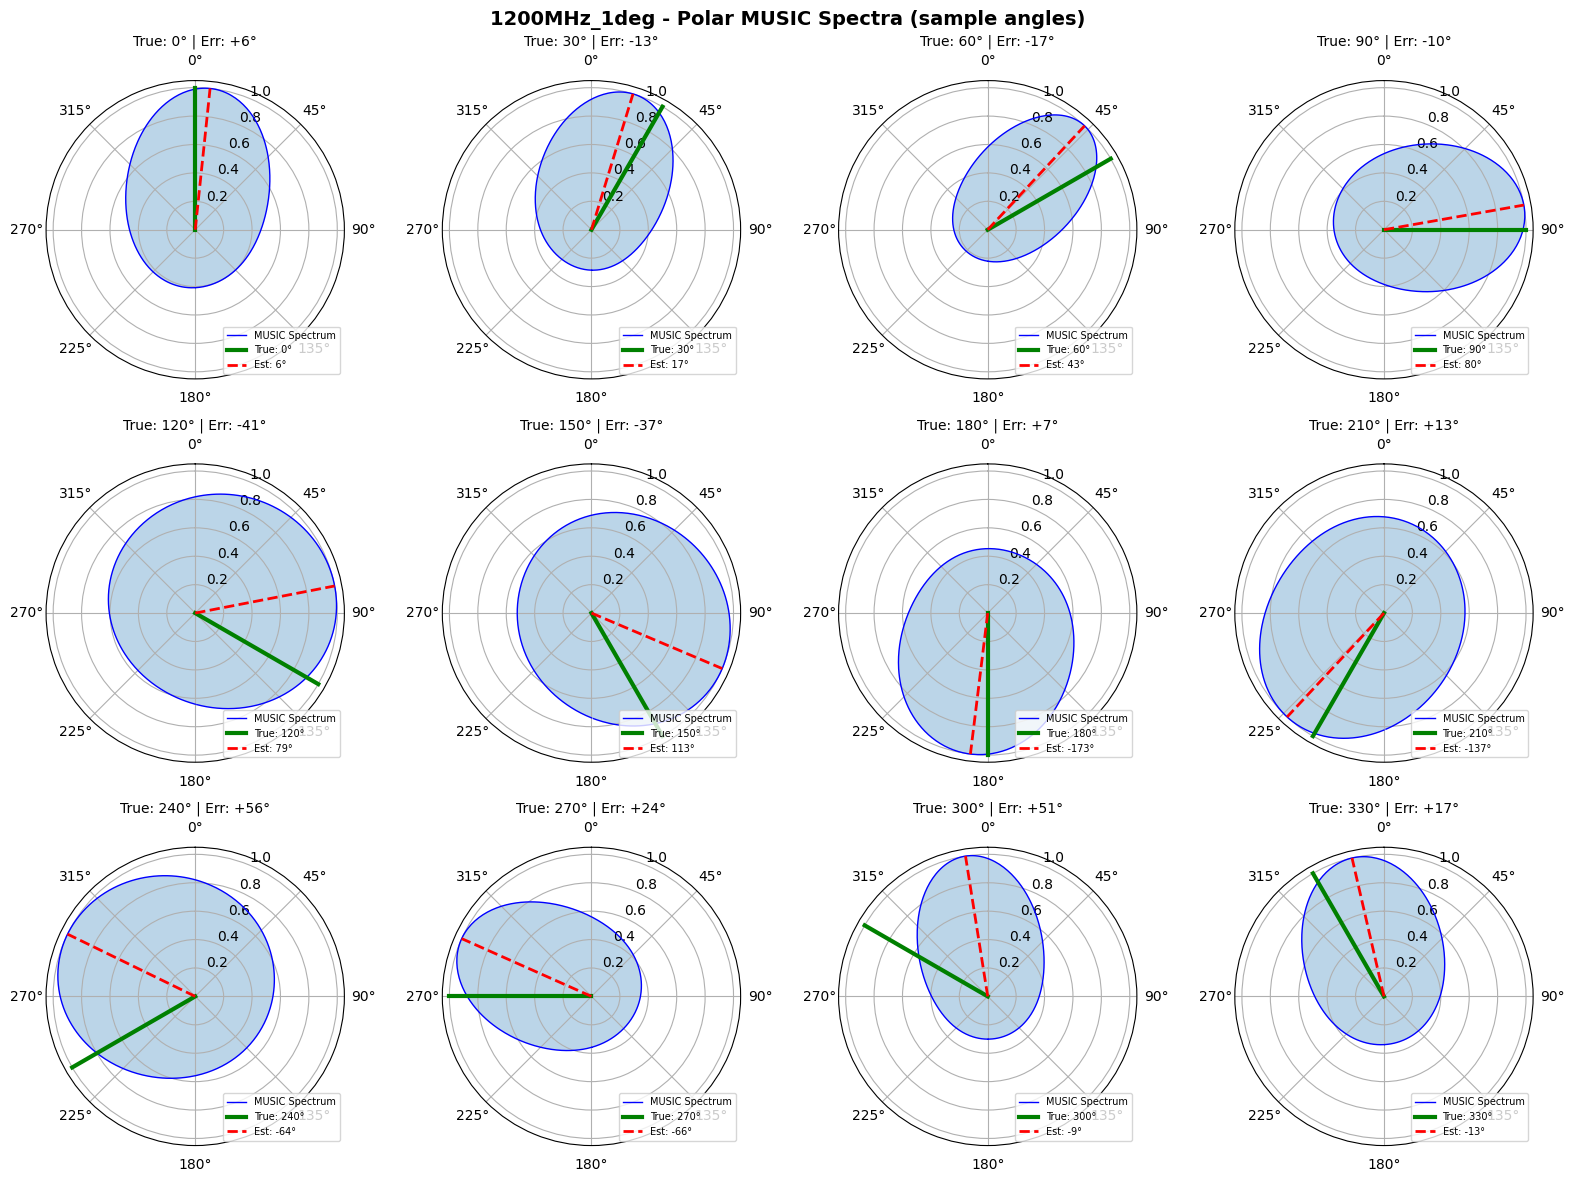


Saved: music_polar_1200MHz_1deg.png


In [18]:
# Select a few representative angles for polar plots
if ANGLE_STEP == 10:
    selected_indices = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33]  # Every 30° for 10° step
else:
    selected_indices = list(range(0, len(results['true_angles']), 30))  # Every 30° for 1° step

# Limit to available indices
selected_indices = [i for i in selected_indices if i < len(results['true_angles'])]

n_selected = len(selected_indices)
n_cols = 4
n_rows = (n_selected + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows), subplot_kw={'projection': 'polar'})
axes = axes.flatten()

for plot_idx, data_idx in enumerate(selected_indices):
    ax = axes[plot_idx]
    
    true_angle = results['true_angles'][data_idx]
    est = results['estimates'][data_idx]
    err = results['errors'][data_idx]
    spectrum = results['spectra'][data_idx]
    
    # Convert to radians for polar plot
    theta = np.deg2rad(angle_grids)
    
    # Normalize spectrum
    spectrum_norm = spectrum / np.max(spectrum)
    
    # Plot spectrum
    ax.plot(theta, spectrum_norm, 'b-', linewidth=1, label='MUSIC Spectrum')
    ax.fill(theta, spectrum_norm, alpha=0.3)
    
    # Mark true angle
    true_rad = np.deg2rad(true_angle if true_angle <= 180 else true_angle - 360)
    ax.plot([true_rad, true_rad], [0, 1], 'g-', linewidth=3, label=f'True: {true_angle}°')
    
    # Mark estimated angle
    est_rad = np.deg2rad(est)
    ax.plot([est_rad, est_rad], [0, 1], 'r--', linewidth=2, label=f'Est: {est}°')
    
    ax.set_title(f'True: {true_angle}° | Err: {err:+.0f}°', fontsize=10)
    ax.set_theta_zero_location('N')  # North at top
    ax.set_theta_direction(-1)  # Clockwise
    ax.legend(loc='lower right', fontsize=7)

# Hide unused axes
for idx in range(n_selected, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(f'{SELECTED_DATASET} - Polar MUSIC Spectra (sample angles)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'music_polar_{SELECTED_DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: music_polar_{SELECTED_DATASET}.png")

## Error Analysis

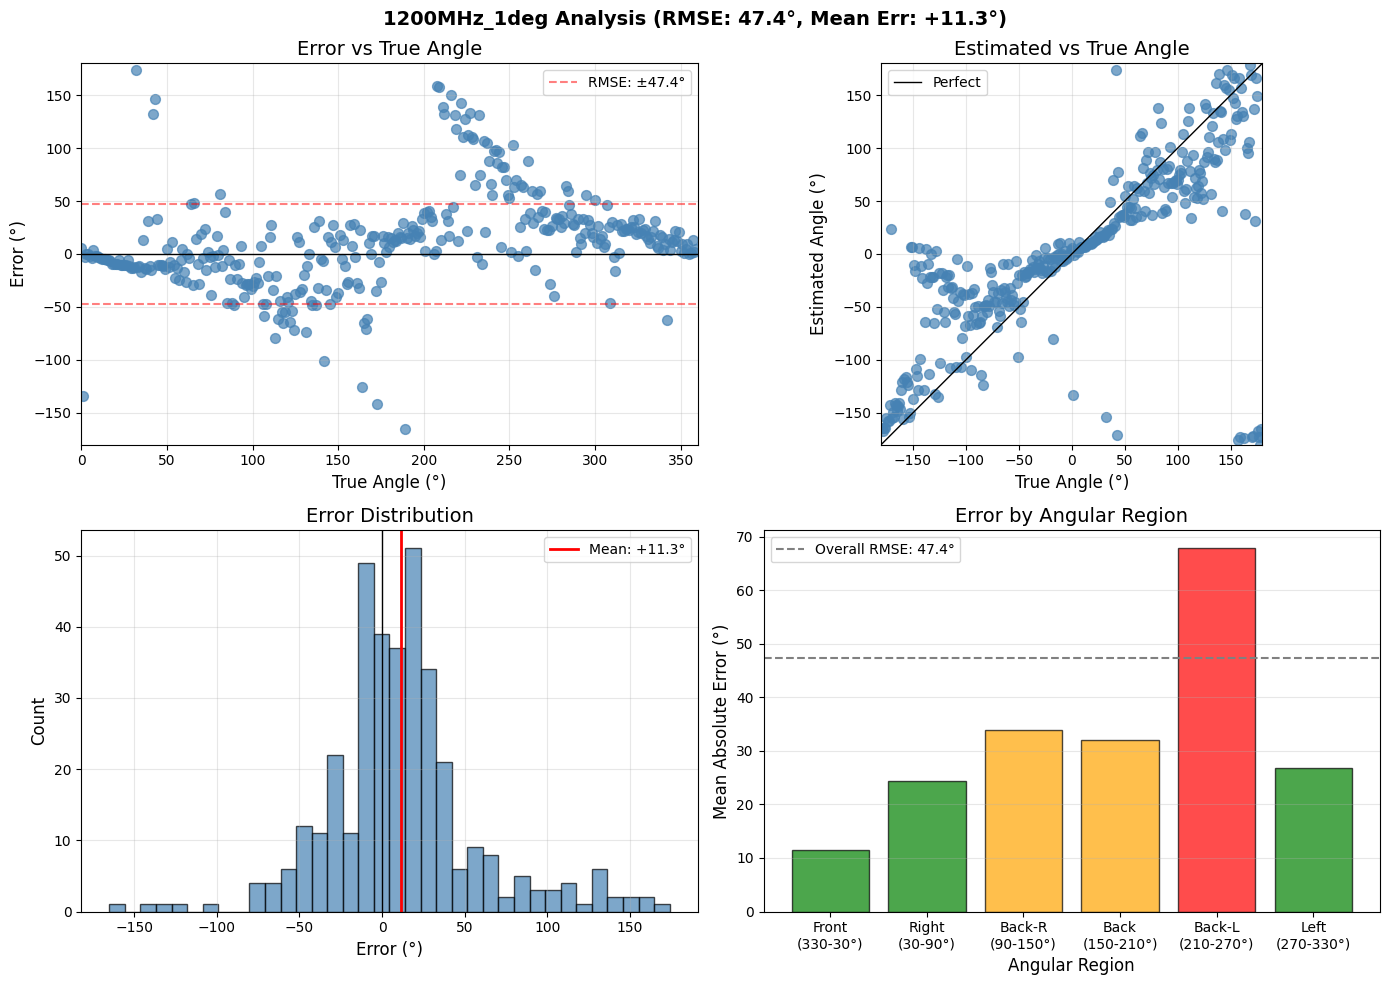


Saved: music_analysis_1200MHz_1deg.png


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Error vs True Angle
ax = axes[0, 0]
ax.scatter(results['true_angles'], results['errors'], alpha=0.7, s=50, c='steelblue')
ax.axhline(0, color='black', linewidth=1)
ax.axhline(rmse, color='red', linestyle='--', alpha=0.5, label=f'RMSE: ±{rmse:.1f}°')
ax.axhline(-rmse, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('True Angle (°)', fontsize=12)
ax.set_ylabel('Error (°)', fontsize=12)
ax.set_title('Error vs True Angle', fontsize=14)
ax.set_xlim(0, 360)
ax.set_ylim(-180, 180)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Estimated vs True
ax = axes[0, 1]
true_adj = [t if t <= 180 else t - 360 for t in results['true_angles']]
ax.plot([-180, 180], [-180, 180], 'k-', linewidth=1, label='Perfect')
ax.scatter(true_adj, results['estimates'], alpha=0.7, s=50, c='steelblue')
ax.set_xlabel('True Angle (°)', fontsize=12)
ax.set_ylabel('Estimated Angle (°)', fontsize=12)
ax.set_title('Estimated vs True Angle', fontsize=14)
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot 3: Error histogram
ax = axes[1, 0]
ax.hist(results['errors'], bins=36, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linewidth=1)
ax.axvline(mean_err, color='red', linewidth=2, label=f'Mean: {mean_err:+.1f}°')
ax.set_xlabel('Error (°)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Error Distribution', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Absolute error by angular region
ax = axes[1, 1]
abs_errors = np.abs(results['errors'])
regions = ['Front\n(330-30°)', 'Right\n(30-90°)', 'Back-R\n(90-150°)', 
           'Back\n(150-210°)', 'Back-L\n(210-270°)', 'Left\n(270-330°)']
region_boundaries = [0, 30, 90, 150, 210, 270, 330, 360]

region_errors = []
for i in range(6):
    if i == 0:  # Front wraps around
        mask = [(t >= 330 or t < 30) for t in results['true_angles']]
    else:
        low, high = region_boundaries[i], region_boundaries[i+1]
        mask = [(low <= t < high) for t in results['true_angles']]
    
    region_abs = [abs_errors[j] for j in range(len(mask)) if mask[j]]
    region_errors.append(np.mean(region_abs) if region_abs else 0)

colors = ['green' if e < 30 else 'orange' if e < 60 else 'red' for e in region_errors]
ax.bar(regions, region_errors, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(rmse, color='gray', linestyle='--', label=f'Overall RMSE: {rmse:.1f}°')
ax.set_xlabel('Angular Region', fontsize=12)
ax.set_ylabel('Mean Absolute Error (°)', fontsize=12)
ax.set_title('Error by Angular Region', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'{SELECTED_DATASET} Analysis (RMSE: {rmse:.1f}°, Mean Err: {mean_err:+.1f}°)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'music_analysis_{SELECTED_DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: music_analysis_{SELECTED_DATASET}.png")

## Summary Table

In [20]:
print("="*70)
print(f"RESULTS SUMMARY: {SELECTED_DATASET}")
print("="*70)
print(f"\n{'True Angle':<12} {'Estimate':<12} {'Error':<12} {'|Error|':<12}")
print("-"*48)

for true_angle, est, err in zip(results['true_angles'], results['estimates'], results['errors']):
    # Color code by error magnitude
    if abs(err) < 20:
        status = "✓"
    elif abs(err) < 45:
        status = "~"
    else:
        status = "✗"
    
    print(f"{true_angle:>8}°    {est:>8}°    {err:>+8.0f}°    {abs(err):>8.0f}°  {status}")

print("-"*48)
print(f"\nStatistics:")
print(f"  RMSE: {rmse:.1f}°")
print(f"  Mean Error: {mean_err:+.1f}°")
print(f"  Std Dev: {np.std(errors):.1f}°")
print(f"  Median |Error|: {np.median(np.abs(errors)):.1f}°")
print(f"  Max |Error|: {np.max(np.abs(errors)):.1f}°")
print(f"\n  Good (<20°): {sum(1 for e in errors if abs(e) < 20)}/{len(errors)}")
print(f"  Moderate (20-45°): {sum(1 for e in errors if 20 <= abs(e) < 45)}/{len(errors)}")
print(f"  Poor (>45°): {sum(1 for e in errors if abs(e) >= 45)}/{len(errors)}")

RESULTS SUMMARY: 1200MHz_1deg

True Angle   Estimate     Error        |Error|     
------------------------------------------------
       0°           6°          +6°           6°  ✓
       1°        -133°        -134°         134°  ✗
       2°          -1°          -3°           3°  ✓
       3°           3°          +0°           0°  ✓
       4°           4°          +0°           0°  ✓
       5°           3°          -2°           2°  ✓
       6°           2°          -4°           4°  ✓
       7°          11°          +4°           4°  ✓
       8°           6°          -2°           2°  ✓
       9°           7°          -2°           2°  ✓
      10°           7°          -3°           3°  ✓
      11°           7°          -4°           4°  ✓
      12°           7°          -5°           5°  ✓
      13°           8°          -5°           5°  ✓
      14°           9°          -5°           5°  ✓
      15°           9°          -6°           6°  ✓
      16°          10°          -6° 

## How to Use

1. **Change dataset**: Modify `SELECTED_DATASET` in cell 3 and re-run all cells
2. **Compare frequencies**: Run with different datasets and compare the saved PNG files
3. **Analyze lobes**: Look at the spectrum plots to understand:
   - Where the main lobe points (should be at true angle)
   - Width of the main lobe (narrower = better resolution)
   - Presence of secondary lobes (can cause ambiguity)

**Background colors in spectrum grid:**
- Green: Error < 20° (good)
- Yellow: Error 20-45° (moderate)
- Red: Error > 45° (poor)